# Neural Net to indentify Craters
A neural network trained on images from NASA that draws bounding boxes for craters in an image

In [1]:
# Some imports
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [2]:
# Directories
root_dir = ".."
data_dir = "data"
NASA_dir = os.path.join(root_dir, data_dir, "NASA")
A15_dir = os.path.join(NASA_dir, "A15")
LRO_dir = os.path.join(NASA_dir, "LRO")
LMS_A15 = os.path.join(A15_dir, "GTF.lms")
LMS_LRO = os.path.join(LRO_dir, "GTF.lms")

In [3]:
def read_lms(file_path):
    '''
    Function to parse .lms file and extract data into a meaningful format
    '''
    f = open(file_path, "r")
    labels = {}
    
    for line in f:
        split = line.split(" : ")[:-1]
        values = []
        for i in range(2, len(split), 4):
            box = (int(split[i]), int(split[i + 1]), int(split[i + 2]), int(split[i + 3]))
            values.append(box)
        labels[split[0]] = values
        
    return labels

# Get labels for LRO images
lro_labels = read_lms(LMS_LRO)

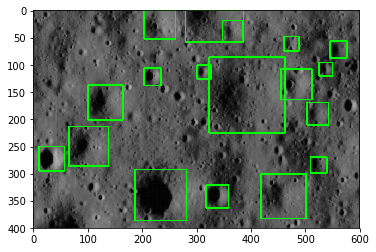

In [4]:
def show_craters(img, craters):
    '''
    Plots the bounding box for craters in the image
    '''
    for crater in craters:
        cv2.rectangle(img, (crater[0], crater[1]), (crater[2], crater[3]), (0, 255, 0), 2)
    plt.imshow(img, cmap='gray')


img_name = "M22091.jpg"
craters = lro_labels[img_name]
img = cv2.imread(os.path.join(LRO_dir, img_name))
show_craters(img, craters)

In [5]:
# Read all LRO images
LRO_files = os.listdir(LRO_dir)
images = {}
for file in LRO_files:
    if file[-3:] == 'jpg':
        images[file] = cv2.imread(os.path.join(LRO_dir, file), 0)

In [6]:
# Format data into arrays
# Repeat image for every crater in image i.e., create a "new" training example
X = []
y = []
for image in images:
    for box in lro_labels[image]:
        X.append(images[image])
        y.append(box)

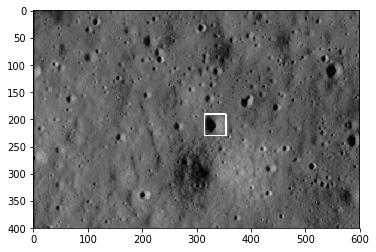

In [7]:
# Make sure we encoded the data properly
# Try changing rand a few times and make sure the bounding box actually finds a crater
rand = 25
temp_img = X[rand]
cv2.rectangle(temp_img, (y[rand][0], y[rand][1]), (y[rand][2], y[rand][3]), 255, 2)
plt.imshow(temp_img, cmap='gray')

We might want to pickle these values. That way, it will be faster to retrieve them. Right now it makes no difference because the dataset we are dealing with is small.

In [8]:
img_height = 400
img_width = 600

# Reformat images and labels as numpy arrays
dataset = np.asarray(X).reshape((-1, img_height * img_width))
labels = np.asarray(y)

m = dataset.shape[0] # Size of training dataset
num_labels = labels.shape[1] # Number of values for each label

In [25]:
# The computation graph

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    train_dataset = tf.placeholder(dtype=tf.float32, shape=(m, img_height * img_width))
    train_labels = tf.constant(labels)
    
    # Variables
    layer1_w = tf.Variable(tf.truncated_normal([img_height * img_width, num_labels]))
    layer1_b = tf.Variable(tf.zeros([num_labels]))
    steps = tf.Variable(0, trainable=False)
    
    # Computation model
    def model(x_train):
        layer2 = tf.matmul(x_train, layer1_w) + layer1_b
        return tf.abs(layer2)
    
    pred = model(train_dataset)
    
    # Loss
    loss = tf.losses.mean_squared_error(labels=train_labels, predictions=pred)
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(3e-10, steps, 100, 0.80, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=steps)
    
    saver = tf.train.Saver()

In [26]:
num_steps = 501

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        _, l = session.run([optimizer, loss], feed_dict={train_dataset: dataset})
        if (step % 10 == 0):
            print('Loss at step %d: %f' % (step, l))
            
            # Backup work to prevent something going wrong at the end of a 10,000 step training
            if (step % 200 == 0):
                save_path = saver.save(session, "./.ckpt/simpleRegression01.ckpt")
    
    save_path = saver.save(session, "./.ckpt/simpleRegression01.ckpt")

Initialized
Loss at step 0: 646638464.000000
Loss at step 10: 238373936.000000
Loss at step 20: 227817952.000000
Loss at step 30: 219826352.000000
Loss at step 40: 212530096.000000
Loss at step 50: 205851136.000000
Loss at step 60: 199725008.000000
Loss at step 70: 194097936.000000
Loss at step 80: 188923504.000000
Loss at step 90: 184156048.000000
Loss at step 100: 179758256.000000
Loss at step 110: 176482480.000000
Loss at step 120: 173403264.000000
Loss at step 130: 170504032.000000
Loss at step 140: 167772720.000000
Loss at step 150: 165196528.000000
Loss at step 160: 162762800.000000
Loss at step 170: 160460240.000000
Loss at step 180: 158280400.000000
Loss at step 190: 156213536.000000
Loss at step 200: 154251088.000000
Loss at step 210: 152752016.000000
Loss at step 220: 151309904.000000
Loss at step 230: 149922960.000000
Loss at step 240: 148587168.000000
Loss at step 250: 147299264.000000
Loss at step 260: 146057424.000000
Loss at step 270: 144858912.000000
Loss at step 280: 1

In [27]:
# Restore weights and biases
with tf.Session(graph=graph) as session:
    print("Restoring checkpoint.")
    saver.restore(session, "./.ckpt/simpleRegression01.ckpt")
    layer1_w = tf.cast(layer1_w, dtype=np.float64).eval()
    layer1_b = tf.cast(layer1_b, dtype=np.float64).eval()
    print("Restored weights and biases")

Restoring checkpoint.
INFO:tensorflow:Restoring parameters from ./.ckpt/simpleRegression01.ckpt
Restored weights and biases


[3028 9332 1369 2631] [-3028.05615456  9332.46947929  1369.15171918 -2631.03592959]


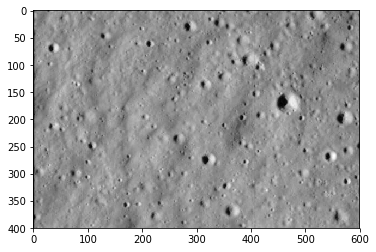

In [34]:
randInt = 4
box = np.matmul(dataset[randInt], layer1_w) + layer1_b
temp = np.absolute(box).astype(int)
print(temp, box)

temp_img = X[randInt]
cv2.rectangle(temp_img, (temp[0], temp[1]), (temp[2], temp[3]), 255, 2)
plt.imshow(temp_img, cmap='gray')

## Neural Network

In [62]:
X_train = np.expand_dims(X, axis=3)
X_train = X_train[:m//2]
labels = labels[:m//2]
print(np.shape(X_train))

(716, 400, 600, 1)


In [70]:
# The computation graph

from math import ceil

num_channels = 1
patch_size = 100
depth = 16
depth2 = 32
num_hidden = 64

graph_2 = tf.Graph()

with graph_2.as_default():
    
    # Input data
    train_dataset = tf.placeholder(dtype=tf.float32, shape=(m // 2, img_height, img_width, num_channels))
    train_labels = tf.constant(labels)
    
    # Variables    
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=([depth])))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth2], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [ceil(img_height / 8) * ceil(img_width / 8) * depth2, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=([num_hidden])))
    layer5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=([num_labels])))
    
    steps = tf.Variable(0, trainable=False)
    
    # Computation model
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.shape.as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.matmul(reshape, layer4_weights) + layer4_biases
        result = tf.matmul(hidden, layer5_weights) + layer5_biases
        return result
    
    pred = model(train_dataset)
    
    # Loss
    loss = tf.losses.mean_squared_error(labels=train_labels, predictions=pred)
    
    # Optimizer
    #learning_rate = tf.train.exponential_decay(3e-10, steps, 100, 1.00, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(3e-1).minimize(loss)#, global_step=steps)
    
    saver = tf.train.Saver()


In [ ]:
num_steps = 501

with tf.Session(graph=graph_2) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        _, l = session.run([optimizer, loss], feed_dict={train_dataset: X_train})
        if (step % 10 == 0):
            print('Loss at step %d: %f' % (step, l))
            
            # Backup work to prevent something going wrong at the end of a 10,000 step training
            if (step % 200 == 0):
                save_path = saver.save(session, "./.ckpt/covnet01.ckpt")
    
    save_path = saver.save(session, "./.ckpt/covnet01.ckpt")

Initialized
